In [1]:
from unstructured.partition.pdf import partition_pdf
import warnings

warnings.filterwarnings('ignore')

# Select the pdf file
file_path = 'Giv - Data Sheet.pdf'

# Partition the PDF file
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",

    extract_image_block_types=["Image"],
    
    extract_image_block_to_payload=True,

    chunking_strategy="by_title",
    max_characters=7000,
    combine_text_under_n_chars=700,
    
)

2025-03-16 21:51:44.542094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Types of elements from partition_pdf
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [3]:
len(chunks)

7

In [4]:
# Composition of elements in a Composite Element
chunks[0].metadata.orig_elements

In [5]:
# Extract the chunks of Image type
elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]

chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'ba5bef97-7bc7-432e-b213-d96d5a55e319',
 'text': 'a — ORC -',
 'metadata': {'detection_class_prob': 0.6471055150032043,
  'coordinates': {'points': ((111.82168579101562, 693.2814331054688),
    (111.82168579101562, 1058.1844482421875),
    (600.1431884765625, 1058.1844482421875),
    (600.1431884765625, 693.2814331054688)),
   'system': 'PixelSpace',
   'layout_width': 1654,
   'layout_height': 2339},
  'last_modified': '2025-02-12T11:12:30',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFtAegDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJ

In [6]:
# List the images (base64)
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

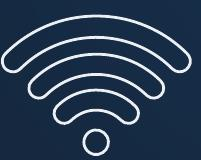

In [7]:
# Define a function to display image
from IPython.display import Image, display
import base64

def display_image(base_64):
    image_data = base64.b64decode(base_64)
    display(Image(data=image_data))

display_image(images[1])

In [8]:
# Image summaries for retrieval
"""
Images can be summarised in batch using any open source LLM with visual input.
In this case we have only a few images which can be manually summarised with better relevance for accurate retrieval.
"""

image_summaries = ["Irrelevant screenshots", "Wifi connectivity", "Rooftop solar panels", "Tool for bracket and fixing", "Battery with a charging sign", "Eco- sustainibility", "Model Bat 5.2 - 5.2 kWh capacity battery", "Model Bat 8.2 - 8.2 kWh capacity battery"]

In [9]:
# List the tables and text
tables = []
texts = []

for chunk in chunks:  
    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)  
    if "CompositeElement" in str(type(chunk)):
        chunk_els = chunk.metadata.orig_elements
        for el in chunk_els:
            if "Table" in str(type(el)):
                tables.append(el)

In [10]:
# Summarise the extracted data
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [11]:
# Prompt
prompt_text = """
You are an assistant tasked with summarising tables and text for retrieval. \
These summaries will be embeddded and used to retrieve the raw text or table elements. \
Give a concise summary of the table or text that is well optimised for retrieval.

Table or text: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(api_key=groq_api_key, temperature=0.5, model="llama-3.1-8b-instant")
summarise_chain = prompt | model | StrOutputParser()

In [12]:
%%time
# Summarised text
text_summaries = summarise_chain.batch(texts, {"max_concurrency": 3})

# Summarised tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarise_chain.batch(tables_html, {"max_concurrency": 3})

CPU times: user 191 ms, sys: 15.4 ms, total: 206 ms
Wall time: 2.98 s


In [13]:
text_summaries

['**GivEnergy Overview**\n\nGivEnergy is a solar energy system suitable for new installations. Key features include:\n\n- Wi-Fi or 3G connectivity\n- Brackets and fixings included\n- 3 kW, 3.6 kW, and 5 kW inverters\n- IP65 rating for multiple siting options\n- 2.6 kWh, 5.2 kWh, and 8.2 kWh modules\n- Flexible rate tariff compatibility\n- Dual MPPT and low maintenance design\n\n**System Specifications**\n\n- Nominal AC output power: 3000W\n- AC apparent power: 3000VA\n- Max output current: 15A\n- Nominal voltage range: 202V - 262V\n- Grid frequency range: 50Hz ± 5Hz\n- Power factor: 0.9 (leading and lagging)\n- THDI: <3%\n- AC connection: Single phase (multiple units for 3 phase)\n\n**Battery and Backup Output**\n\n- Battery power: 3000W\n- Max charging/discharge current: 60A\n- Backup output: 3000VA\n- Peak power: 3600VA (10s)\n- Output voltage: 230Vac ± 2% (50Hz or 60Hz)\n- THDV: <3% (linear load)\n- Efficiency: up to 97.10% (Euro-ETA: 96.5%)\n\n**Protection and Safety Features**\n\n

In [14]:
table_summaries

['**Summary of the Table:**\n\nThe table describes an inverter with the following key features:\n\n- **Model:** THDI\n- **AC Connection:** Single Phase (multiple units can be installed for 3 Phase)\n- **Power Source:** Battery Power with a Nominal Power of 3000W and a Max Charging/Discharging Current of 60A\n- **Backup Output:** 3000VA with a Peak Power of 3600VA for 10s\n- **Efficiency:** Up to 97.10%\n- **Protection Devices:** Includes Output Over Current Protection, Output Over voltage Protection, Ground Fault Monitoring, and Grid Monitoring\n- **Physical Characteristics:** Weighs 19kg and operates within a temperature range of -25°C to 60°C\n\n**Retrieval Keywords:**\n\n- THDI\n- Inverter\n- Single Phase\n- Battery Power\n- Backup Output\n- Efficiency\n- Protection Devices\n- Weight\n- Operating Temperature Range\n\nThis summary provides a concise overview of the key features and specifications of the inverter, making it easier to retrieve the raw text elements.',
 '**Summary of Ke

In [15]:
image_summaries

['Irrelevant screenshots',
 'Wifi connectivity',
 'Rooftop solar panels',
 'Tool for bracket and fixing',
 'Battery with a charging sign',
 'Eco- sustainibility',
 'Model Bat 5.2 - 5.2 kWh capacity battery',
 'Model Bat 8.2 - 8.2 kWh capacity battery']

In [16]:
# Load data to vectorstore
import uuid
from langchain_chroma import Chroma  
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings  
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Vectorstore to use child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# Storage layer for parent documents
store = InMemoryStore()
id_key = "doc_id"

# Retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore = vectorstore,
    docstore = store,
    id_key=id_key,
)

In [17]:
%%time
# Generate unique IDs
doc_ids = [str(uuid.uuid4()) for _ in texts]
table_ids = [str(uuid.uuid4()) for _ in tables]
img_ids = [str(uuid.uuid4()) for _ in images]

# Create summary documents with both content and ID metadata
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) 
    for i, summary in enumerate(text_summaries)
]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) 
    for i, summary in enumerate(table_summaries)
]
summary_images = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) 
    for i, summary in enumerate(image_summaries)
]

# Add the Document objects to the vectorstore
retriever.vectorstore.add_documents(summary_texts)
retriever.vectorstore.add_documents(summary_tables)
retriever.vectorstore.add_documents(summary_images)

# Store the original documents in docstore
retriever.docstore.mset(list(zip(doc_ids, texts)))
retriever.docstore.mset(list(zip(table_ids, tables)))
retriever.docstore.mset(list(zip(img_ids, images)))

CPU times: user 284 ms, sys: 25.1 ms, total: 309 ms
Wall time: 1.79 s


In [18]:
# Check retriever
chunks = retriever.invoke(
    "Find documents about solar inverter."
)
for chunk in chunks:
    print(type(chunk))

<class 'str'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.CompositeElement'>
<class 'unstructured.documents.elements.CompositeElement'>


In [19]:
# RAG Pipeline functions
from langchain_core.messages import SystemMessage, HumanMessage
from unstructured.documents.elements import Table, CompositeElement

# Parse the documents into images (Base64), tables, and text
def parse_docs(docs):
    r_image = []
    r_table = []
    r_text = []

    for doc in docs:
        if isinstance(doc, str):  
            r_image.append(doc)  
        elif isinstance(doc, Table):
            r_table.append(doc)  
        elif isinstance(doc, CompositeElement):
            r_text.append(str(doc))  

    return {"retrieved images": r_image, "retrieved tables": r_table, "retrieved texts": r_text}

# Construct prompts with context (dictionary)
prompt_template = """
Act as a product expert for GivEnergy hardware products.
The context provided below contains technical specifications for related devices. 
Your task is to process the context and generate an accurate, concise response to the user's question. 
If the exact answer is not explicitly available in the context, infer and compose the answer based on the surrounding details, 
keywords, and related information in the context.
Respond with a clear, concise, and accurate answer.
Do not include any introductions, complains, suggestions, additional commentary or explanations.
Context text: 
{context_text}

Context Tables: 
{context_tables}

User Question: {question}
    """

def build_prompt(kwargs):
    # Extract context and question from kwargs
    context_text = kwargs["context"]  
    tables = kwargs["tables"]  
    question = kwargs["question"]  
    
    # Format the context sections
    context_text = " ".join([str(text) for text in context_text])  
    context_tables = "\n".join([str(table) for table in tables])  
    context_tables = context_tables if context_tables else "No relevant tables."

    # Construct the formatted prompt using the provided template
    formatted_prompt = prompt_template.format(
        context_text=context_text,
        context_tables=context_tables,
        question=question
    )

    return [
        SystemMessage(content="You are a helpful assistant knowledgeable in Retrieval-Augmented Generation."),
        HumanMessage(content=formatted_prompt)
    ]

In [20]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

openai_api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(api_key=openai_api_key, temperature=0.5, model="gpt-4o-mini")

# RAG Pipeline
rag_chain = (
    {
        "context": (
            retriever 
            | RunnableLambda(parse_docs)
            | RunnableLambda(lambda docs: docs["retrieved texts"])
        ),
        "tables": (
            retriever 
            | RunnableLambda(parse_docs)
            | RunnableLambda(lambda docs: docs["retrieved tables"])
        ),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | llm
    | StrOutputParser()
)

In [21]:
# Function to handle displaying images (multiple or none)
def handle_images(images):
    if not images:
        print("No images found.")
    else:
        for image in images:
            display_image(image)
            
img_display = (
    retriever 
    | RunnableLambda(parse_docs)
    | RunnableLambda(lambda docs: docs["retrieved images"])
    | RunnableLambda(handle_images)
)

In [22]:
# Run inference for retrieval of extracted data from the pdf
your_question = "What are the avialable battery models?"


 RAG Response:  The available battery models are Bat 2.6 and Bat 5.2.


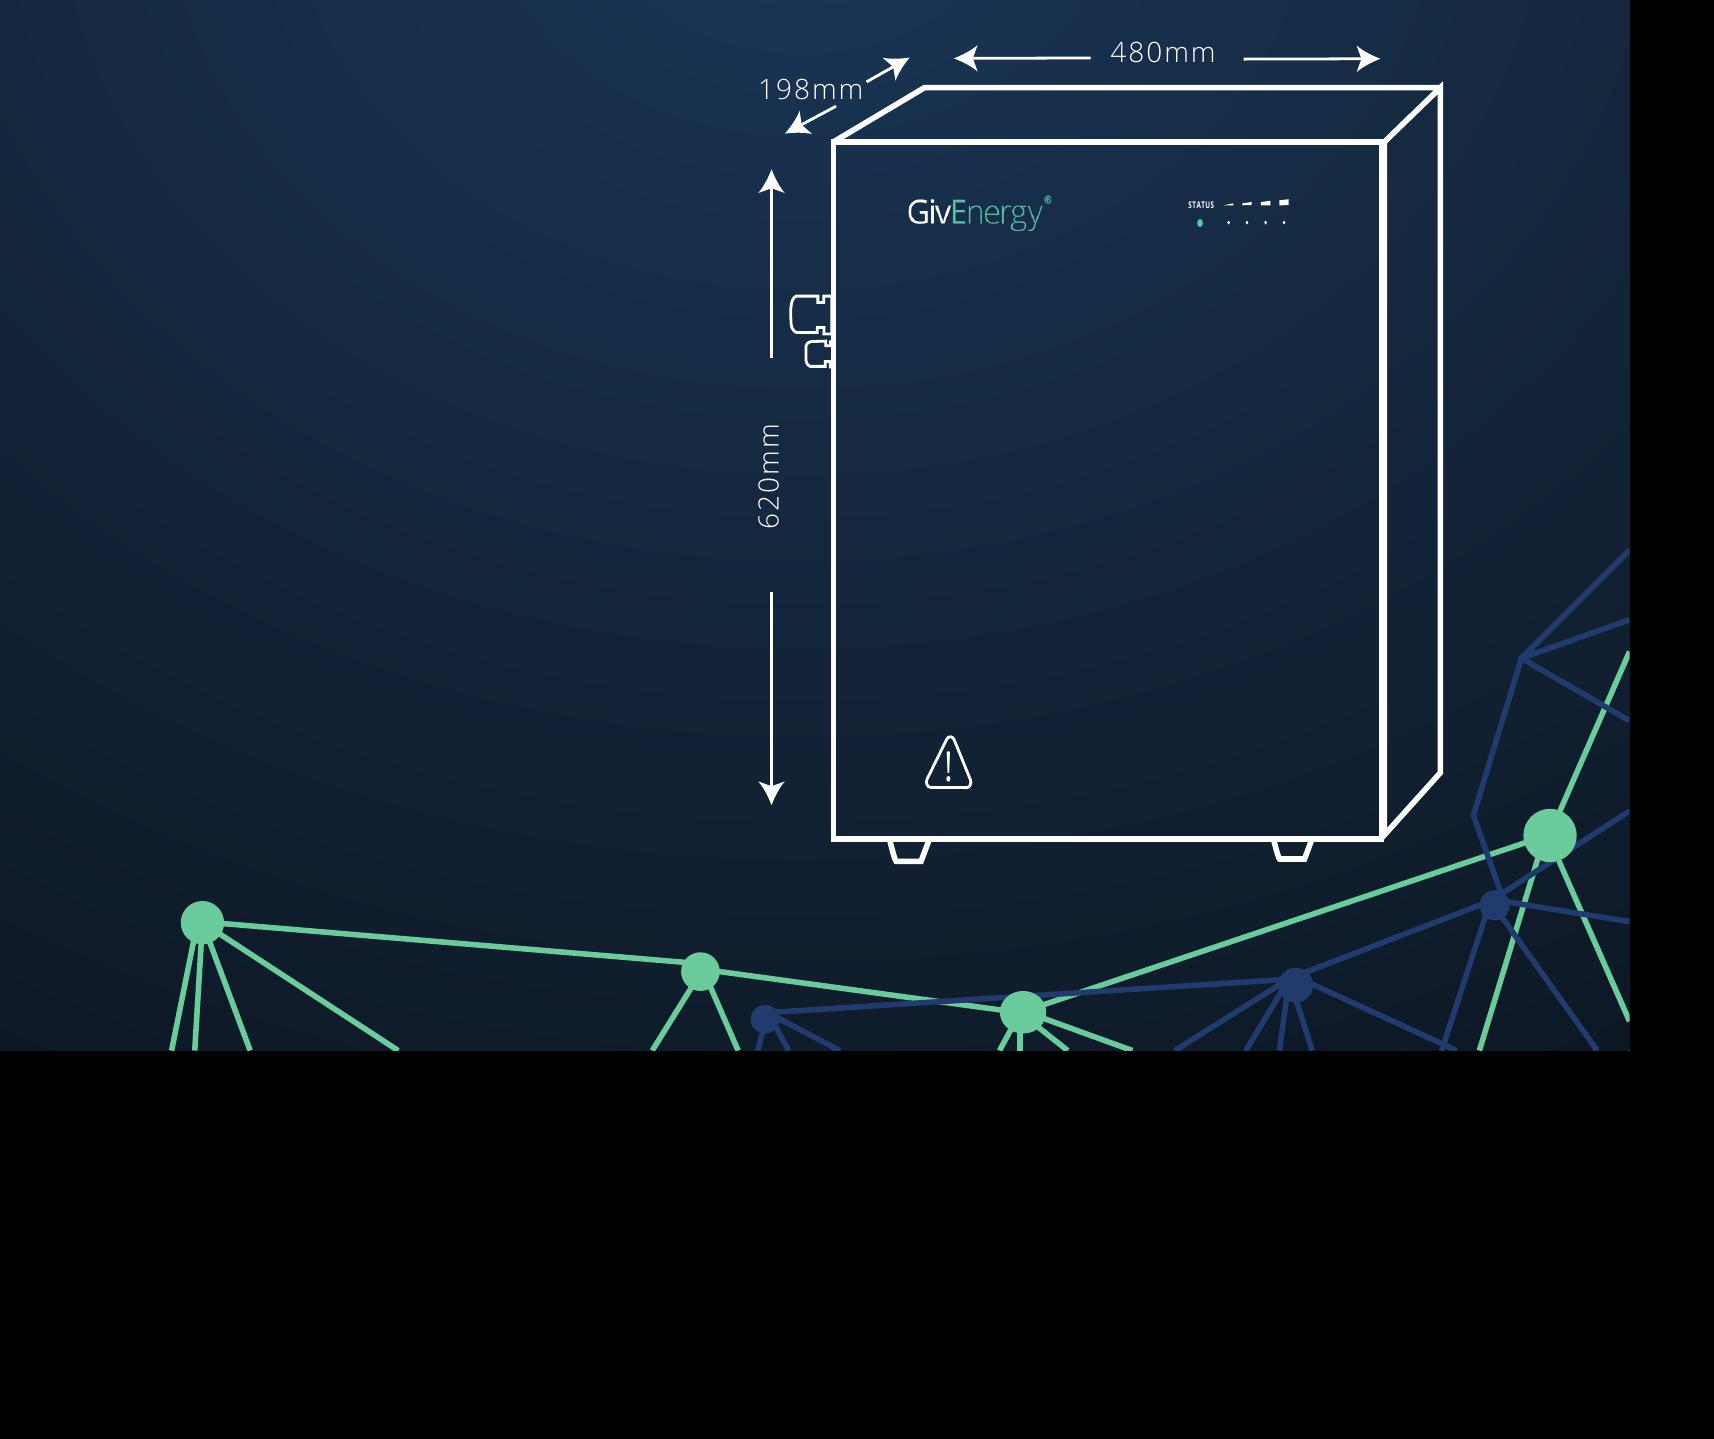

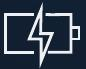

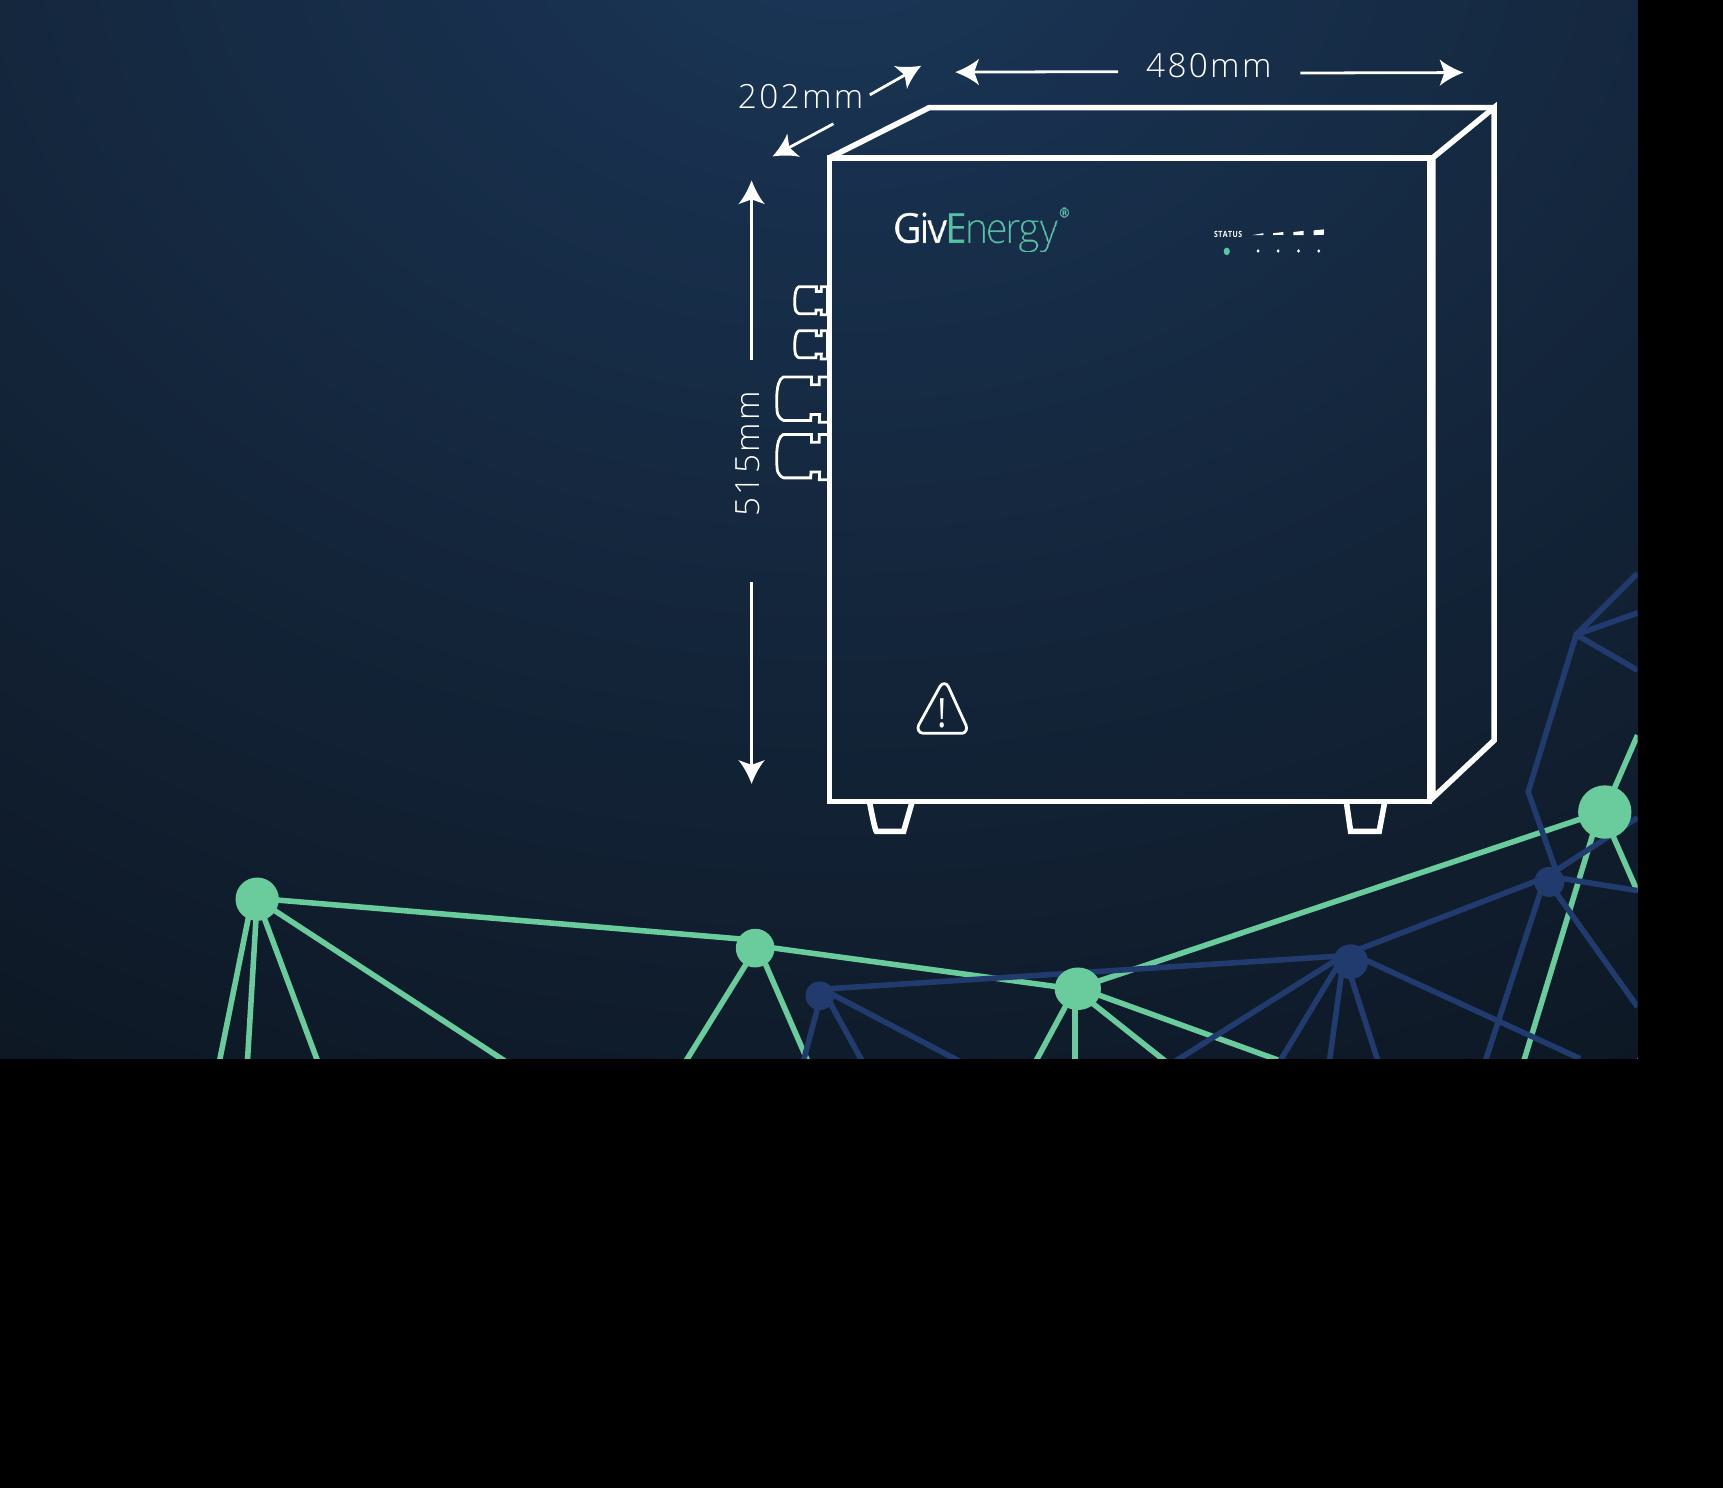

CPU times: user 115 ms, sys: 9.46 ms, total: 124 ms
Wall time: 1.53 s


In [23]:
%%time
# Invoke
response = rag_chain.invoke(your_question)

# Print the RAG Response
print("\n RAG Response: ", response)
img_display.invoke(your_question)


 Your Question: What are the avialable battery models?

 Retrieved Text Context:
['Model Bat 2.6\n\nCapacity Voltage Current Technology IP Grade BMS\n\nRobust\n\nLife Cycling (90% DOD, 25°C) Operating Temperature Storage Temperature Warranty BTT Standard Weight\n\nElectrical Parameters\n\nOperating Voltage Range Maximum Charging Voltage Maximum Charging / Discharging Current Network Interface Communication Protocols Advantages\n\n2.6kWh / 51Ah 51.2VDC 30A LiFePO4 Cell |P65 Multi Point Monitoring BMS Pre 10 Years -10°C - 55°C -30°C -60°C 26MWh / 10 Years UN 38.3, IEC61000 32kg\n\nInstalled\n\n43.2V - 58.5V DC 59V DC 30A / 30A RS485 Modbus Stackable, BMS Upgradeable, IP65\n\n220mm <——— 480mm —__» y —_\n\nModel Bat 5.2\n\nCapacity\n\nVoltage Current Technology IP Grade BMS Life Cycling (100% DOD, 25°C) Operating Temperature Storage Temperature Warranty BTT Standard Weight']

 No table context available.

 Retrieved Image Context:


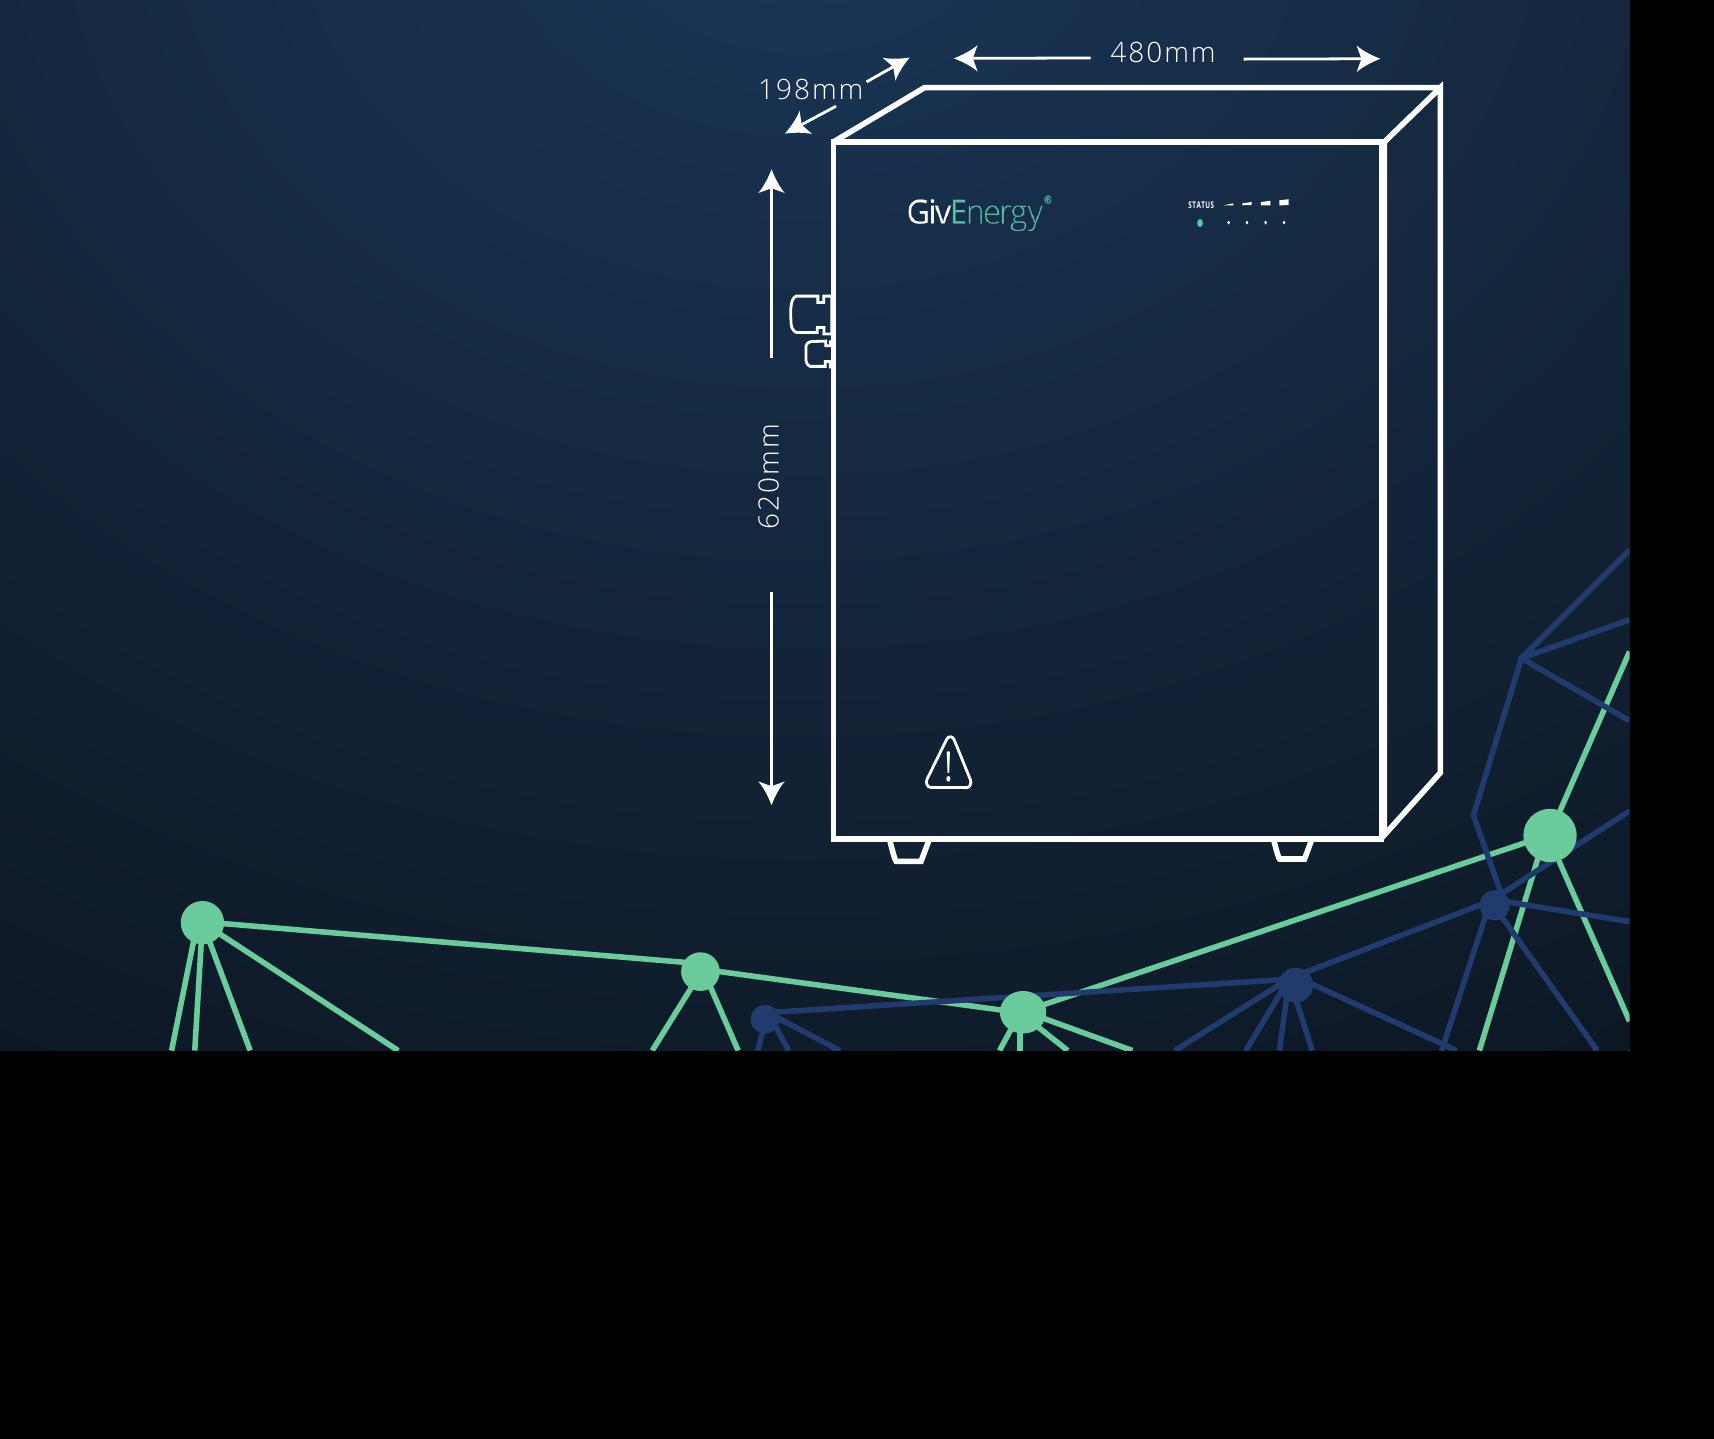

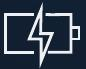

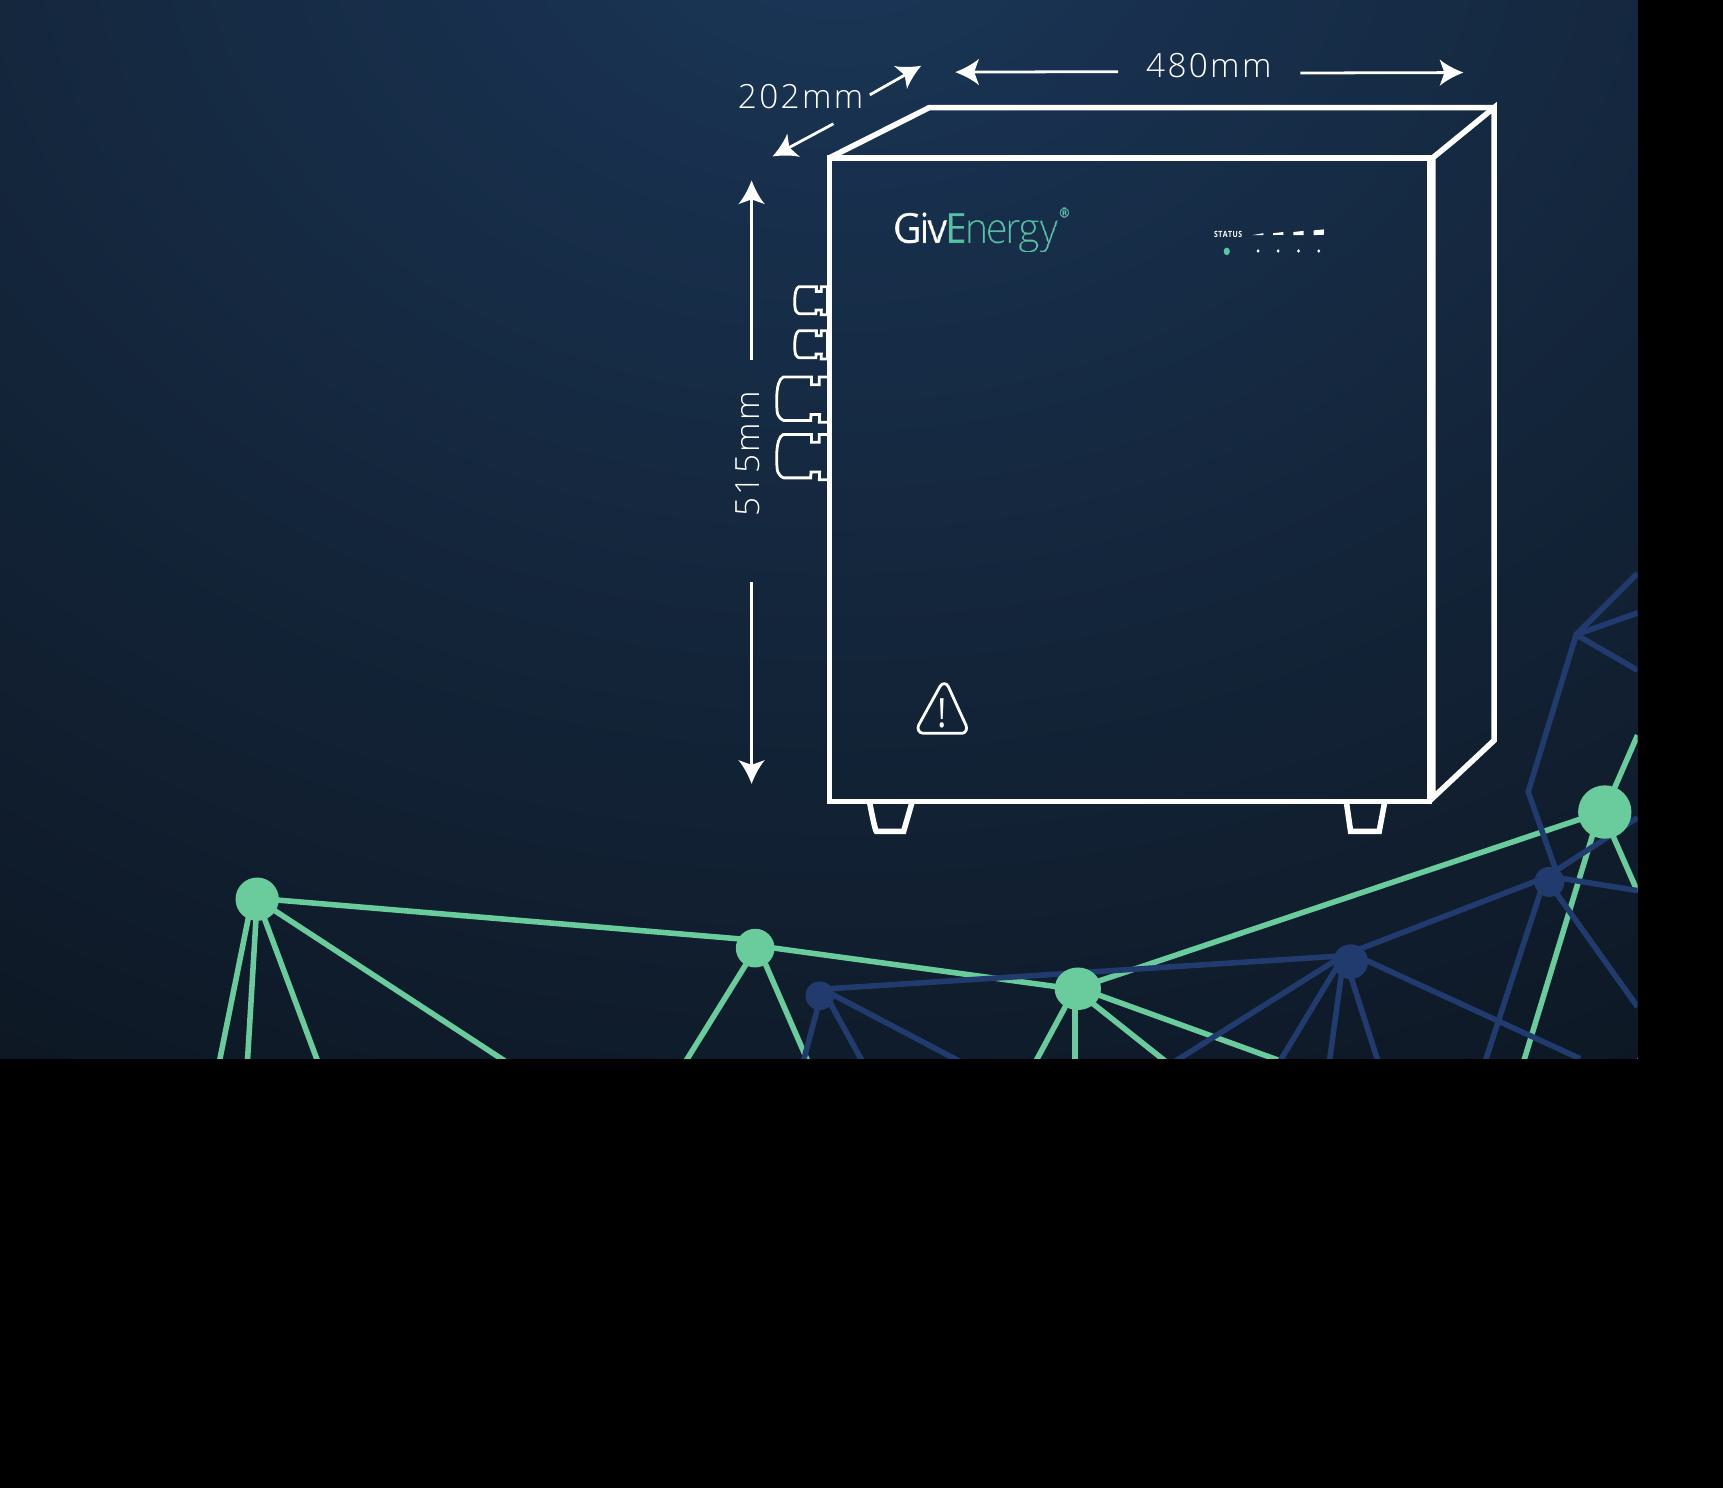

In [24]:
# Verification
print("\n Your Question:", your_question)
retrieved_context = retriever.invoke(your_question)  
parsed_context = parse_docs(retrieved_context)

# Print text context
if parsed_context["retrieved texts"]:
    print("\n Retrieved Text Context:")
    print(parsed_context["retrieved texts"])
else:
    print("\n No text context available.")

# Print table context
if parsed_context["retrieved tables"]:
    print("\n Retrieved Table Context:")
    print(parsed_context["retrieved tables"])
else:
    print("\n No table context available.")

# Print image context
if parsed_context["retrieved images"]:
    print("\n Retrieved Image Context:")
    handle_images(parsed_context["retrieved images"])
else:
    print("\n No image context available.")